In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CNCnoise_1.csv to CNCnoise_1.csv


In [ ]:
data = pd.read_csv("CNCnoise_1.csv", header=None)
data.columns = ['noise']

In [ ]:
# 윈도우 시계열 구성
def create_dataset(data, look_back=10):
    X = []
    for i in range(len(data) - look_back):
        window = data[i:(i + look_back)].values.flatten()
        X.append(window)
    return np.array(X)

In [ ]:
# === 파라미터 설정 영역 ===
look_back = 10  # 과거 시점 길이 (입력 특징 벡터 구성용)

# K-means 변수
kmeans_n_clusters = 2  # 클러스터 수

# 이동 평균 기반 이상 탐지 변수
ma_window_size = 1000  # 이동 평균 윈도우 크기
ma_k = 2.5             # 표준편차 곱 (이상치 임계값 설정용)

# Isolation Forest 변수
iso_window_size = 1000  # 슬라이딩 윈도우 크기
iso_step = 500          # 윈도우 이동 간격
iso_contamination = 0.05  # 이상치 비율

In [ ]:
# === 시계열 특징 벡터 구성 ===
X = create_dataset(data['noise'], look_back)
noise_full = data['noise'].values[look_back:]

# === 이동 평균 및 임계값 계산 ===
rolling_mean = pd.Series(noise_full).rolling(window=ma_window_size, center=True).mean()
rolling_std = pd.Series(noise_full).rolling(window=ma_window_size, center=True).std()
upper_bound = rolling_mean + ma_k * rolling_std
lower_bound = rolling_mean - ma_k * rolling_std

In [ ]:
# === 1. K-means 이상치 탐지 ===
kmeans = KMeans(n_clusters=kmeans_n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
distances = np.linalg.norm(X - kmeans.cluster_centers_[kmeans_labels], axis=1)

# 이동 평균 기반 임계값으로 이상치 판단
is_outlier_kmeans = (noise_full > upper_bound.values) | (noise_full < lower_bound.values)

In [ ]:
# === 2. Isolation Forest 이상치 탐지 (윈도우 기반) ===
is_outlier_iso = np.zeros(len(noise_full), dtype=bool)

# 슬라이딩 윈도우 적용
for start in range(0, len(X) - iso_window_size, iso_step):
    end = start + iso_window_size
    X_window = X[start:end]

    # 모델 학습 및 예측
    model = IsolationForest(contamination=iso_contamination, random_state=42)
    preds = model.fit_predict(X_window)

    # 이상치는 -1
    is_outlier_iso[start:end] |= (preds == -1)

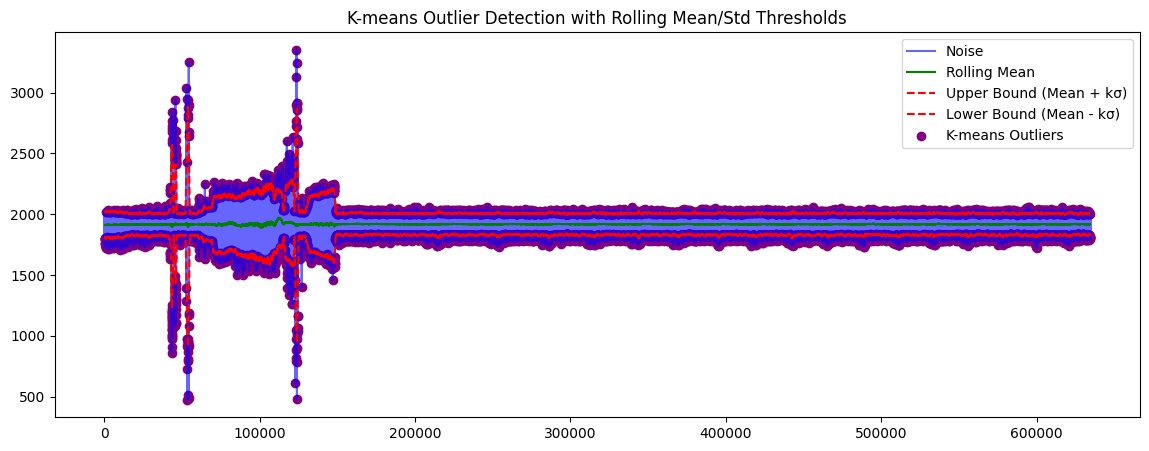

In [ ]:
# 시각화  - K-means
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (Mean + kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (Mean - kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_kmeans)[0], noise_full[is_outlier_kmeans], color='purple', label='K-means Outliers')
plt.title("K-means Outlier Detection with Rolling Mean/Std Thresholds")
plt.legend()
plt.show()


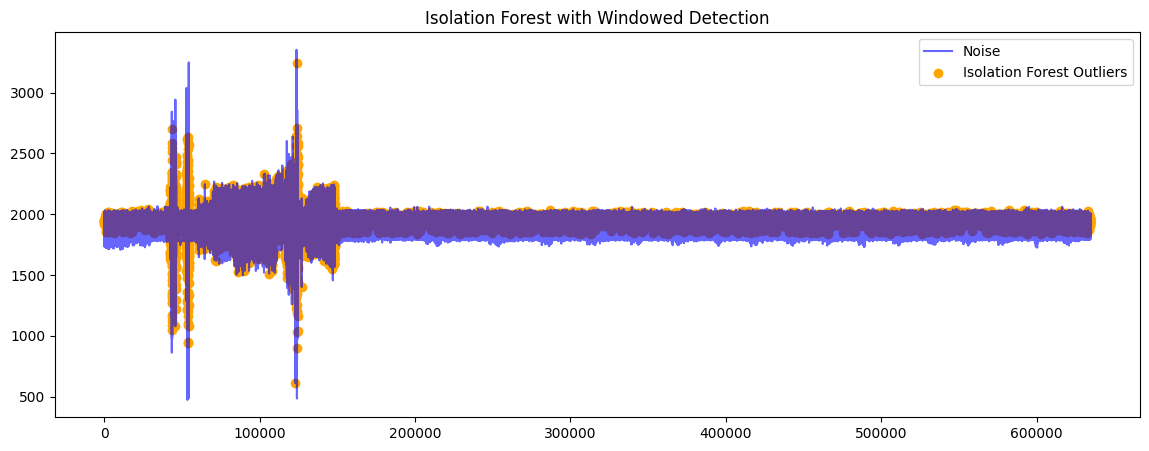

In [ ]:
# 시각화 - Isolation Forest
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.scatter(np.where(is_outlier_iso)[0], noise_full[is_outlier_iso], color='orange', label='Isolation Forest Outliers')
plt.title("Isolation Forest with Windowed Detection")
plt.legend()
plt.show()

In [ ]:
# K-means 기준값 조정
ma_window_size = 2000  # 이전보다 더 긴 윈도우로 안정화
ma_k = 3.0             # 임계 범위 확장

# Isolation Forest 조정
iso_contamination = 0.02  # 낮은 이상치 비율로 안정 구간 오탐 방지

In [ ]:
# 다시 계산: 이동 평균 및 임계값
rolling_mean = pd.Series(noise_full).rolling(window=ma_window_size, center=True).mean()
rolling_std = pd.Series(noise_full).rolling(window=ma_window_size, center=True).std()
upper_bound = rolling_mean + ma_k * rolling_std
lower_bound = rolling_mean - ma_k * rolling_std

In [ ]:
# 다시 계산: K-means 이상치 판정
is_outlier_kmeans = (noise_full > upper_bound.values) | (noise_full < lower_bound.values)


# 다시 계산: Isolation Forest 결과 초기화
is_outlier_iso = np.zeros(len(noise_full), dtype=bool)

for start in range(0, len(X) - iso_window_size, iso_step):
    end = start + iso_window_size
    X_window = X[start:end]

    model = IsolationForest(contamination=iso_contamination, random_state=42)
    preds = model.fit_predict(X_window)
    is_outlier_iso[start:end] |= (preds == -1)

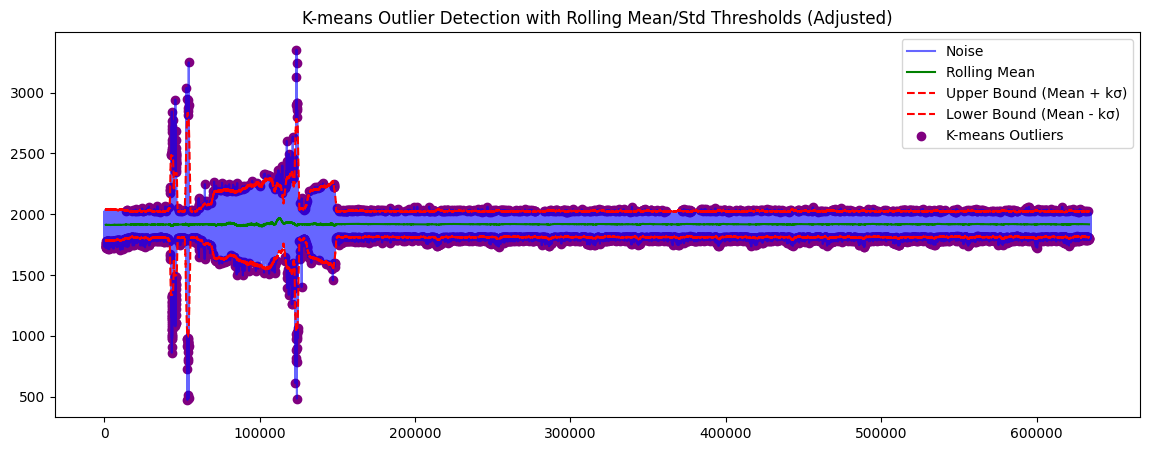

In [ ]:
# K-means 시각화
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (Mean + kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (Mean - kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_kmeans)[0], noise_full[is_outlier_kmeans], color='purple', label='K-means Outliers')
plt.title("K-means Outlier Detection with Rolling Mean/Std Thresholds (Adjusted)")
plt.legend()
plt.show()

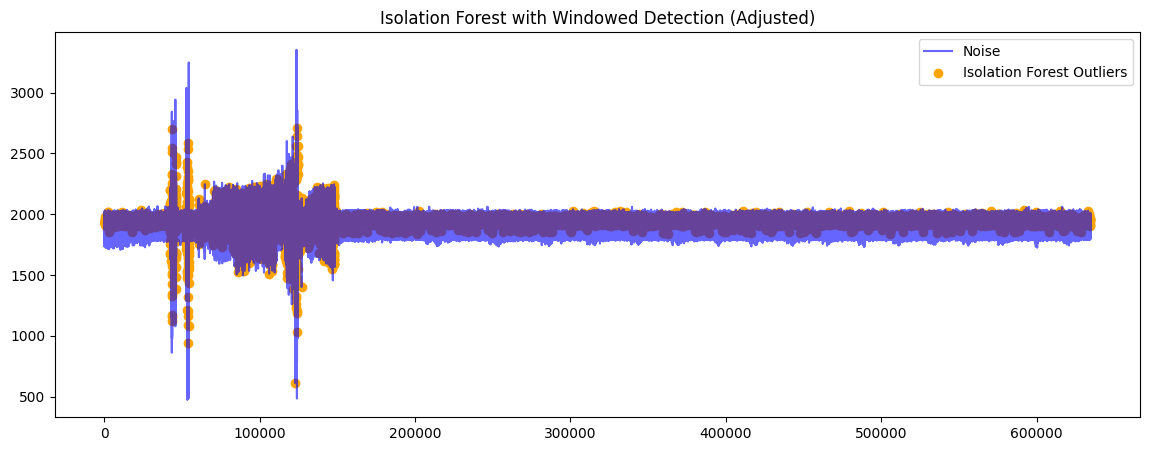

In [ ]:
# Isolation Forest 시각화
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.scatter(np.where(is_outlier_iso)[0], noise_full[is_outlier_iso], color='orange', label='Isolation Forest Outliers')
plt.title("Isolation Forest with Windowed Detection (Adjusted)")
plt.legend()
plt.show()

In [ ]:
look_back = 50  # 또는 100
X = create_dataset(data['noise'], look_back)
noise_full = data['noise'].values[look_back:]

iso_contamination = 0.01  # 매우 안정된 주기 구간에서 오탐 줄임

In [ ]:
rolling_mean = pd.Series(noise_full).rolling(window=ma_window_size, center=True).mean()
rolling_std = pd.Series(noise_full).rolling(window=ma_window_size, center=True).std()
upper_bound = rolling_mean + ma_k * rolling_std
lower_bound = rolling_mean - ma_k * rolling_std

In [ ]:
kmeans = KMeans(n_clusters=kmeans_n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
distances = np.linalg.norm(X - kmeans.cluster_centers_[kmeans_labels], axis=1)

is_outlier_kmeans = (noise_full > upper_bound.values) | (noise_full < lower_bound.values)

In [ ]:
is_outlier_iso = np.zeros(len(noise_full), dtype=bool)

for start in range(0, len(X) - iso_window_size, iso_step):
    end = start + iso_window_size
    X_window = X[start:end]

    model = IsolationForest(contamination=iso_contamination, random_state=42)
    preds = model.fit_predict(X_window)
    is_outlier_iso[start:end] |= (preds == -1)

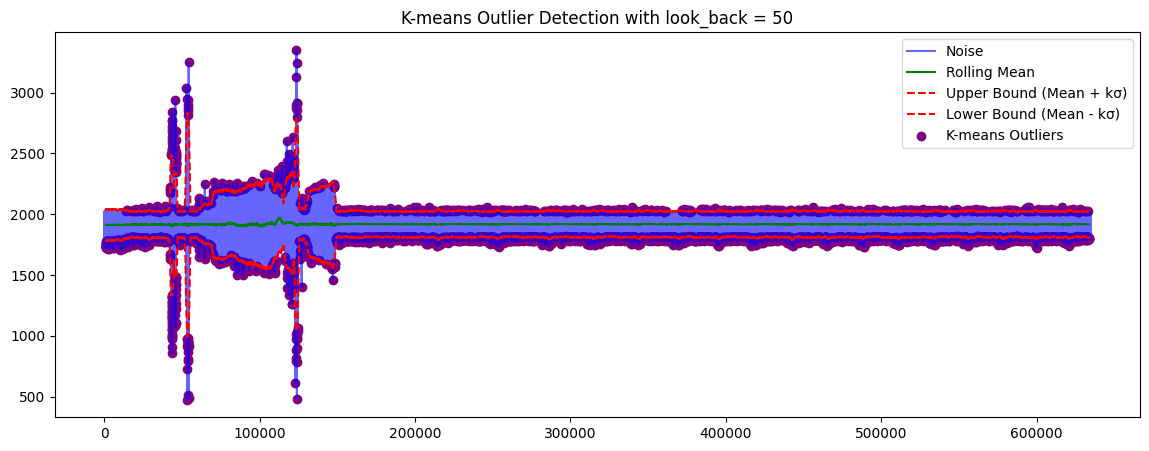

In [ ]:
# K-means 시각화
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (Mean + kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (Mean - kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_kmeans)[0], noise_full[is_outlier_kmeans], color='purple', label='K-means Outliers')
plt.title("K-means Outlier Detection with look_back = {}".format(look_back))
plt.legend()
plt.show()

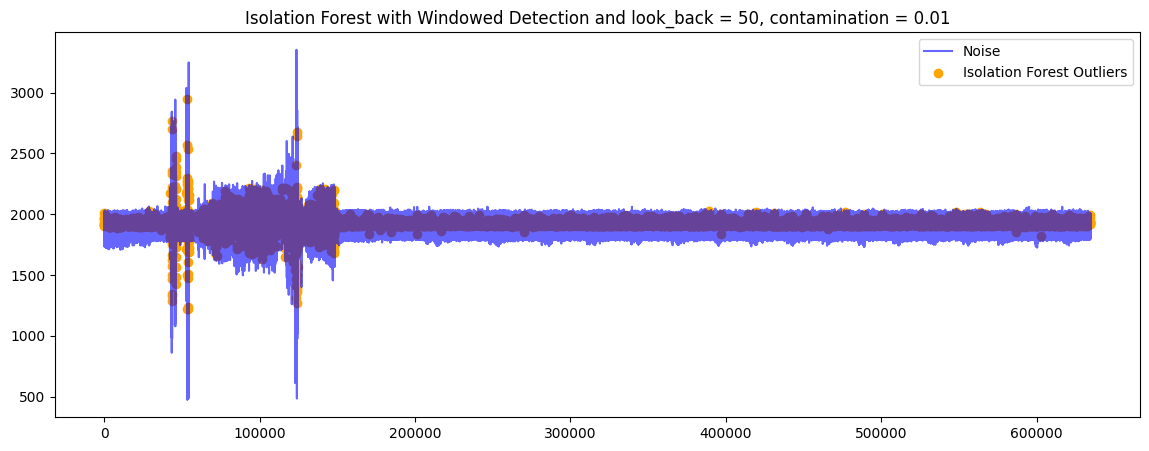

In [ ]:
# Isolation Forest 시각화
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.scatter(np.where(is_outlier_iso)[0], noise_full[is_outlier_iso], color='orange', label='Isolation Forest Outliers')
plt.title("Isolation Forest with Windowed Detection and look_back = {}, contamination = {}".format(look_back, iso_contamination))
plt.legend()
plt.show()

In [ ]:
# 파라미터 미세 조정
ma_k = 6.0
ma_window_size = 8000

In [ ]:
# 이동 평균 기준 재계산
rolling_mean = pd.Series(noise_full).rolling(window=ma_window_size, center=True).mean()
rolling_std = pd.Series(noise_full).rolling(window=ma_window_size, center=True).std()
upper_bound = rolling_mean + ma_k * rolling_std
lower_bound = rolling_mean - ma_k * rolling_std

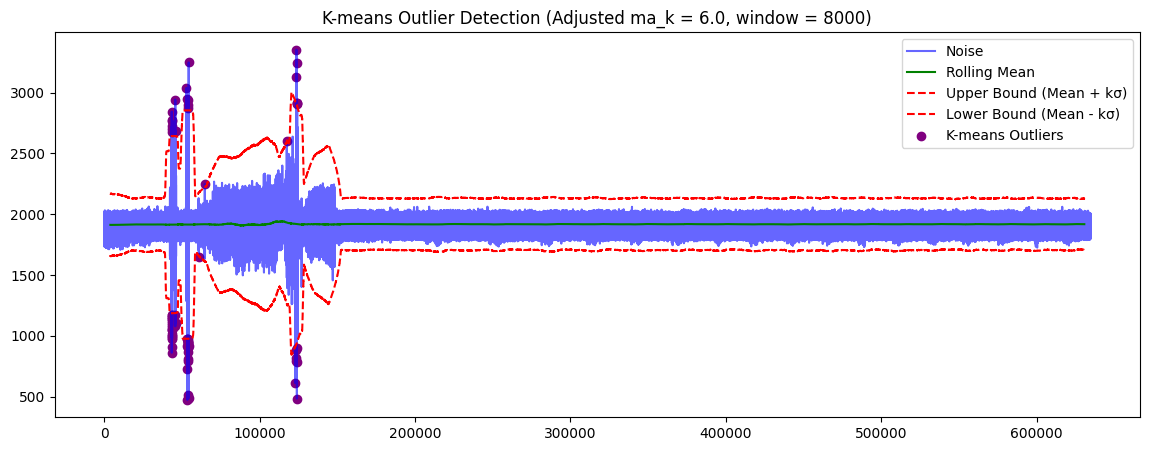

In [ ]:
# K-means 이상치 재판단
is_outlier_kmeans = (noise_full > upper_bound.values) | (noise_full < lower_bound.values)

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (Mean + kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (Mean - kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_kmeans)[0], noise_full[is_outlier_kmeans], color='purple', label='K-means Outliers')
plt.title("K-means Outlier Detection (Adjusted ma_k = {}, window = {})".format(ma_k, ma_window_size))
plt.legend()
plt.show()

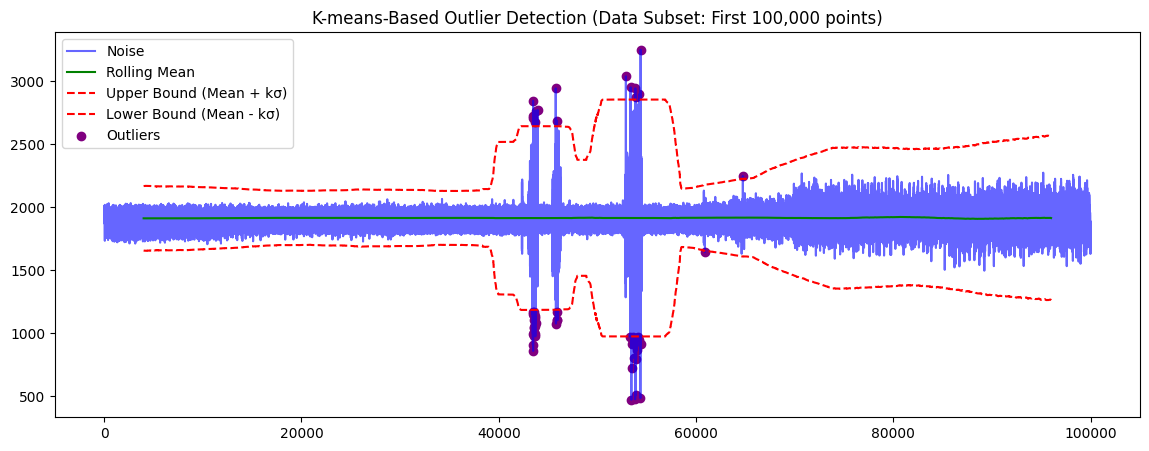

In [ ]:
# 데이터 앞 100,000개만 추출 (look_back 고려)
cut = 100000
subset = data.iloc[:cut + look_back].copy()  # look_back 만큼 추가

# 다시 look_back 적용
X_cut = create_dataset(subset['noise'], look_back=look_back)
noise_cut = subset['noise'].values[look_back:]

# rolling 재계산
rolling_mean = pd.Series(noise_cut).rolling(window=ma_window_size, center=True).mean()
rolling_std = pd.Series(noise_cut).rolling(window=ma_window_size, center=True).std()
upper_bound = rolling_mean + ma_k * rolling_std
lower_bound = rolling_mean - ma_k * rolling_std

# 이상치 판단
is_outlier_cut = (noise_cut > upper_bound.values) | (noise_cut < lower_bound.values)

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(noise_cut, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (Mean + kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (Mean - kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_cut)[0], noise_cut[is_outlier_cut], color='purple', label='Outliers')
plt.title("K-means-Based Outlier Detection (Data Subset: First 100,000 points)")
plt.legend()
plt.show()


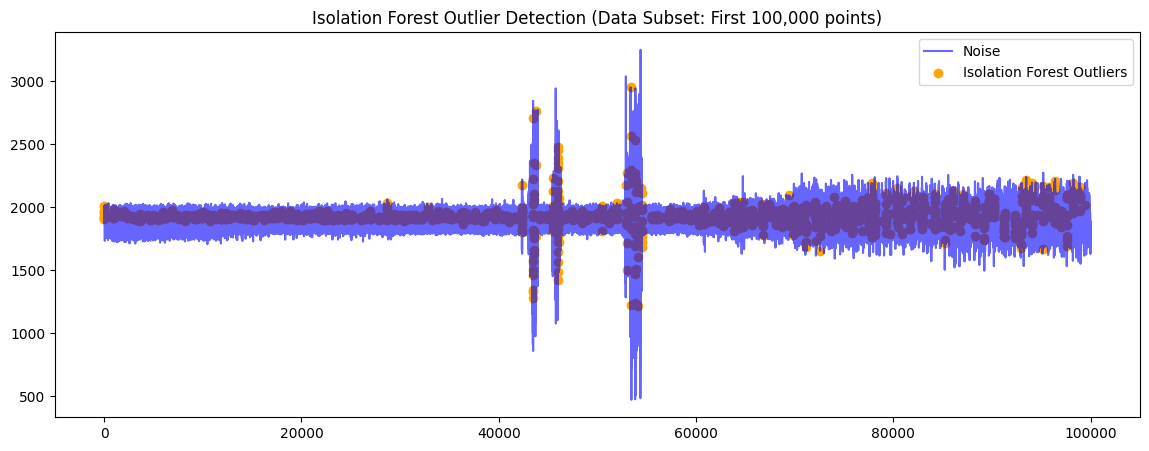

In [ ]:
# 데이터 앞 100,000개만 추출 (look_back 고려)
cut = 100000
subset = data.iloc[:cut + look_back].copy()  # look_back 만큼 추가

# 특징 벡터 생성
X_cut = create_dataset(subset['noise'], look_back=look_back)
noise_cut = subset['noise'].values[look_back:]

# 이상치 결과 초기화
is_outlier_iso_cut = np.zeros(len(noise_cut), dtype=bool)

# 슬라이딩 윈도우 기반 이상치 탐지
for start in range(0, len(X_cut) - iso_window_size, iso_step):
    end = start + iso_window_size
    X_window = X_cut[start:end]

    model = IsolationForest(contamination=iso_contamination, random_state=42)
    preds = model.fit_predict(X_window)
    is_outlier_iso_cut[start:end] |= (preds == -1)

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(noise_cut, label='Noise', color='blue', alpha=0.6)
plt.scatter(np.where(is_outlier_iso_cut)[0], noise_cut[is_outlier_iso_cut], color='orange', label='Isolation Forest Outliers')
plt.title("Isolation Forest Outlier Detection (Data Subset: First 100,000 points)")
plt.legend()
plt.show()
